# **Gesture Recognition**
Imagine you are working as a data scientist at a home electronics company that manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.


---


 

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

1. Thumbs up:  Increase the volume
2. Thumbs down: Decrease the volume
3. Left swipe: 'Jump' backwards 10 seconds
4. Right swipe: 'Jump' forward 10 seconds  
5. Stop: Pause the movie

## **Business constraint**
1. Infrence time should be very low.

## 1. Getting Data into Drive

In [ ]:
!wget --header="Host: doc-10-ao-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_unm0q6n476f32h7ago3jna292l2crup9_nonce=ata74920ilveu" --header="Connection: keep-alive" "https://doc-10-ao-docs.googleusercontent.com/docs/securesc/ocj5g5i98smf7h037l8383nkr1imnpof/l2gi5ib4rav5grbpsigrm8i23j3etnvq/1632150750000/10375629365358872077/14165932214061485598/1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL?e=download&authuser=0&nonce=ata74920ilveu&user=14165932214061485598&hash=3namt58s0h6gejanok8donlst74c7gim" -c -O 'Project_data.zip'

In [ ]:
!unzip "/content/Project_data.zip"

In [ ]:
!pip install scipy==1.1.0

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 2. Data Generator

In [6]:
import scipy
import numpy as np
import os
from scipy.misc import *
import datetime
import os

In [7]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [8]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
batch_size = 2

In [9]:
frames = 30 # x is the number of images you use for each video
height = 64; width = 64; # the final size of the input images
channel = 3 #RGB
classes = 5 #5 gestures

In [49]:

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,x)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z, channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = temp[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = temp[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = temp[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = temp[:,:,0]
                    batch_data[folder,idx,:,:,1] = temp[:,:,1]
                    batch_data[folder,idx,:,:,2] = temp[:,:,2]
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = "/content/Project_data/train"
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20  # choose the number of epochs
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


## 3. Model-1 3D convolution Model

In [21]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten,\
                         TimeDistributed, BatchNormalization,\
                         Activation, Dropout, Input, MaxPool3D,\
                         MaxPool2D
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.models import Model


In [15]:
def Model_1():
    input_layer = Input((x, y, z, channel))
    # convolutional layers
    conv_layer1 = Conv3D(filters=16, kernel_size=(3, 3, 3),
                         activation='relu',
                         kernel_initializer='he_normal',
                         padding='same',
                         name='Conv_1')(input_layer)
    pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer1)
    conv_layer2 = Conv3D(filters=32, kernel_size=(3, 3, 3),
                         activation='relu',
                         kernel_initializer='he_normal',
                         padding='same')(pooling_layer1)
    pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

    conv_layer3 = Conv3D(filters=64, kernel_size=(3, 3, 3),
                         activation='relu',
                         kernel_initializer='he_normal',
                         padding='same',
                         kernel_regularizer='l2')(pooling_layer2)
    pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer3)

    conv_layer4 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu',
                         kernel_initializer='he_normal',
                         padding='same',
                         kernel_regularizer='l2')(pooling_layer3)
    pooling_layer4 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

    flatten_layer = Flatten()(pooling_layer4)
    dense_layer1 = Dense(units=128,
                         activation='relu',
                         kernel_initializer='he_normal')(flatten_layer)
    dense_layer2 = Dense(units=64,
                         activation='relu',
                         kernel_initializer='he_normal')(dense_layer1)

    output_layer = Dense(units=5, activation='softmax')(dense_layer2)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model
    

In [16]:
K.clear_session()
model = Model_1()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 64, 64, 3)]   0         
_________________________________________________________________
Conv_1 (Conv3D)              (None, 30, 64, 64, 16)    1312      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 32, 32, 16)    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 15, 32, 32, 32)    13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 16, 16, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 16, 16, 64)     55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 8, 8, 64)       0     

In [17]:
def Train_Model_1():
    optimiser = tf.keras.optimizers.Adam(0.0001, amsgrad=True)
    mertics = tf.keras.metrics.CategoricalAccuracy(name='acc')

    model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=mertics)

    filepath = '/content/Models/Model_1.h5'

    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='min')

    ER = EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=1,
        mode="min",
        baseline=None,
        restore_best_weights=True
    )
    # write the REducelronplateau code here
    LR = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.3,
                           patience=5,
                           verbose=1)

    callbacks_list = [checkpoint, LR, ER]

    if (num_train_sequences % batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences % batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    history = model.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list,
                        validation_data=val_generator,
                        validation_steps=validation_steps,
                        class_weight=None, workers=1,
                        initial_epoch=0)
    return history


In [18]:
history = Train_Model_1()

Source path =  /content/Project_data/train ; batch size = 2
Epoch 1/20
332/332 [==============================] - 101s 253ms/step - loss: 4.7520 - acc: 0.2534 - val_loss: 4.0407 - val_acc: 0.3400

Epoch 00001: val_loss improved from inf to 4.04070, saving model to /content/Models/Model_1.h5
Epoch 2/20
332/332 [==============================] - 49s 148ms/step - loss: 3.8132 - acc: 0.3705 - val_loss: 3.4185 - val_acc: 0.5200

Epoch 00002: val_loss improved from 4.04070 to 3.41855, saving model to /content/Models/Model_1.h5
Epoch 3/20
332/332 [==============================] - 49s 148ms/step - loss: 3.3243 - acc: 0.4066 - val_loss: 3.1072 - val_acc: 0.3800

Epoch 00003: val_loss improved from 3.41855 to 3.10716, saving model to /content/Models/Model_1.h5
Epoch 4/20
332/332 [==============================] - 49s 147ms/step - loss: 2.9285 - acc: 0.4880 - val_loss: 2.8216 - val_acc: 0.4500

Epoch 00004: val_loss improved from 3.10716 to 2.82162, saving model to /content/Models/Model_1.h5
Epo

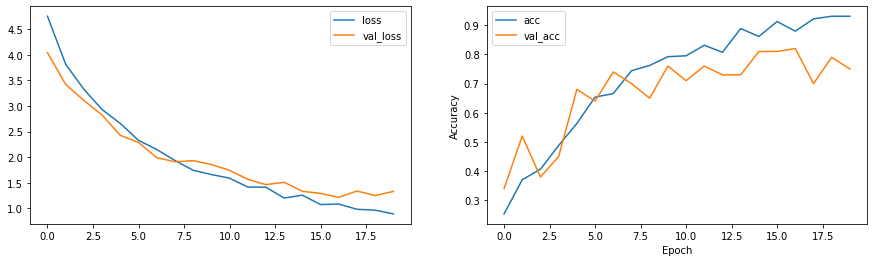

In [19]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].legend(['loss', 'val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])
axes[1].legend(['acc', 'val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


## Model-2 CNN+RNN

In [140]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM, GRU


In [259]:
# Initiakize the required parameters
batch_size = 10
num_epochs = 50
x = 30 # x is the number of images you use for each video
y = 150; z = 150; # (y,z) is the final size of the input images
channel = 3 #RGB
classes = 5 #5 gestures

In [260]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [261]:
backbone =tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(150,150,3),
    pooling='max',
)

29097984/29084464 [==============================] - 0s 0us/step


In [270]:
backbone.trainable=True

In [271]:
len(backbone.layers)

428

In [278]:
for layer in backbone.layers[:400]:
  layer.trainable =  False

In [279]:
# Model declaration
def Model_2():
    model_2 = Sequential()
    model_2.add(TimeDistributed(backbone, input_shape=(x, y, z, channel)))
    model_2.add(BatchNormalization())
    model_2.add(TimeDistributed(Flatten()))
    model_2.add(GRU(16, return_sequences=True))
    model_2.add(GRU(32, return_sequences=True))
    model_2.add(GRU(64, return_sequences=True))
    model_2.add(GRU(128, return_sequences=False))
    model_2.add(Dense(16, activation='relu',
                kernel_regularizer='l2',
                kernel_initializer="he_normal"))
    model_2.add(Dense(32, activation='relu',
                kernel_regularizer='l2',
                kernel_initializer="he_normal"))
    model_2.add(Dense(64, activation='relu',
                kernel_regularizer='l2',
                kernel_initializer="he_normal"))
    model_2.add(Dense(128, activation='relu',
                kernel_regularizer='l2',
                kernel_initializer="he_normal"))
    model_2.add(Dropout(0.5))
    model_2.add(Dense(classes, activation='softmax'))
    return model_2


In [280]:
tf.keras.backend.clear_session()
K.clear_session()
model_2 = Model_2()
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 1024)          7037504   
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 1024)          4096      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 30, 16)            49968     
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 32)            4704      
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 64)            18624     
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               7

In [281]:
import logging
import os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf


def Train_Model_2():
    optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)
    mertics = tf.keras.metrics.CategoricalAccuracy(name='acc')

    model_2.compile(optimizer=optimiser,
                    loss='categorical_crossentropy',
                    metrics=mertics)
    filepath = '/content/Models/Model_CNN_RNN.h5'

    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_loss', verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='min')
    ER = EarlyStopping(
        monitor="val_loss",
        patience=15,
        verbose=1,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )
    LR = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.3, patience=5,
                           verbose=1)
    callbacks_list = [checkpoint, LR, ER]
    batch_size = 16
    if (num_train_sequences % batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences % batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    history = model_2.fit(train_generator,
                          steps_per_epoch=steps_per_epoch,
                          epochs=100, verbose=1,
                          callbacks=callbacks_list,
                          validation_data=val_generator,
                          validation_steps=validation_steps,
                          class_weight=None, workers=1,
                          initial_epoch=0)
    return history


In [282]:
history_2 = Train_Model_2()

Source path =  /content/Project_data/train ; batch size = 10
Epoch 1/100
42/42 [==============================] - 78s 1s/step - loss: 6.4001 - acc: 0.2262 - val_loss: 6.3242 - val_acc: 0.3571

Epoch 00001: val_loss improved from inf to 6.32416, saving model to /content/Models/Model_CNN_RNN.h5
Epoch 2/100
42/42 [==============================] - 46s 1s/step - loss: 6.2707 - acc: 0.2313 - val_loss: 6.1510 - val_acc: 0.3286

Epoch 00002: val_loss improved from 6.32416 to 6.15105, saving model to /content/Models/Model_CNN_RNN.h5
Epoch 3/100
42/42 [==============================] - 29s 702ms/step - loss: 6.1320 - acc: 0.2143 - val_loss: 5.9052 - val_acc: 0.4143

Epoch 00003: val_loss improved from 6.15105 to 5.90523, saving model to /content/Models/Model_CNN_RNN.h5
Epoch 4/100
42/42 [==============================] - 30s 725ms/step - loss: 5.9252 - acc: 0.4286 - val_loss: 5.8277 - val_acc: 0.3429

Epoch 00004: val_loss improved from 5.90523 to 5.82772, saving model to /content/Models/Model_

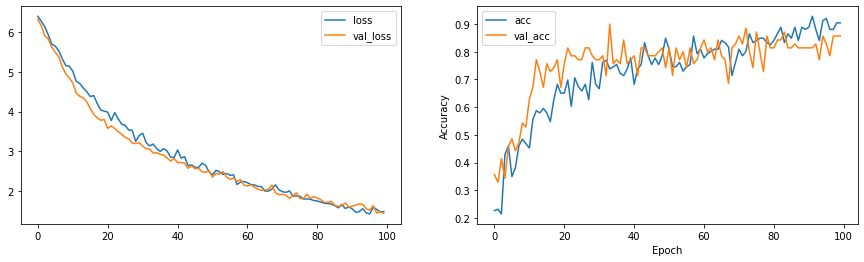

In [283]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history_2.history['loss'])   
axes[0].plot(history_2.history['val_loss'])
axes[0].legend(['loss','val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
axes[1].plot(history_2.history['acc'])   
axes[1].plot(history_2.history['val_acc'])
axes[1].legend(['acc','val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# **Conclusion**

In [3]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model Name", "Number of Trainable Parameters", "Epochs","Accuracy", "Validation Accuracy"])
  
# Add rows
myTable.add_row(["3D CNN", "562,693",'20', "93%", "75%"])
myTable.add_row(["2D CNN + GRU", "688,069",'100', "90%", "85%"])
  
print(myTable)

+--------------+--------------------------------+--------+----------+---------------------+
|  Model Name  | Number of Trainable Parameters | Epochs | Accuracy | Validation Accuracy |
+--------------+--------------------------------+--------+----------+---------------------+
|    3D CNN    |            562,693             |   20   |   93%    |         75%         |
| 2D CNN + GRU |            688,069             |  100   |   90%    |         85%         |
+--------------+--------------------------------+--------+----------+---------------------+
